Блок кода для визуализации процесса обучения модели:

In [1]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    output = []
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      output.append(self._history_dict[key])
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
    return np.array(output)

  def display(self,groups = None):
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

# Задание 1. Создание полносвязной сети

1. Создайте двухслойную* полносвязную нейронную сеть средствами Pytorch.
2. Обучите ее на CIFAR10.
3. Посмотрите график зависимости loss и accuracy от эпохи в процессе обучения.

Для создания полносвязанных слоев используйте класс [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)

*Рекомендуется использовать скрытый слой со 128 нейронами.

Загрузим датасет с помощью средств PyTorch.

In [8]:
import torch
import torch.nn as nn
from tqdm import trange
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cuda available: {torch.cuda.is_available()} \n")

Cuda available: True 



Что бы результаты экспериментов воспроизводились зафиксируем seed's

In [4]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In [9]:
from torch.utils.data import random_split
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


trainset, valset, _  = random_split(dataset, [12000, 3000, 35000])


Files already downloaded and verified
Files already downloaded and verified


Опишите структуру сети: полносвязные слои + [функции активации](https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity) на ваш выбор.

Здесь **не** используйте `nn.Sequential`, чтобы была возможность изменять функцию активации в существующем экземпляре класса (потребуется для 5 задания).




In [7]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(3*32*32, 128)
        self.layer2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        return x

**Блок обучения. Можно использовать без изменений.**

Пример с более подробным [описанием блока обучения в документации Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)


Обратите внимание на то, что в PyTorch моделях не используется метод fit, как в sklearn. Код, отвечающий за обучение, пишется отдельно.

Определим batch_size и создадим два DataLoader'a для обучающей и тестовой части

In [9]:
batch_size = 256

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подсчёт точности:

In [5]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs.to(device))
        loss += criterion(pred, labels.to(device))
        correct += get_correct_count(pred.cpu(),labels.cpu())
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

**Основной цикл обучения.**

Определим его как отдельную функцию.


In [6]:
def train(model, criterion, optimizer, num_epochs=25, tag="cifar10"):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for imgs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            outputs = outputs.cpu() #logits
            ouputs_prob = nn.Softmax(dim=1)(outputs)
            labels = labels.cpu()
            correct += get_correct_count(ouputs_prob,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val = calaculate_accuracy(model,val_loader,criterion)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)

        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])

    return pp

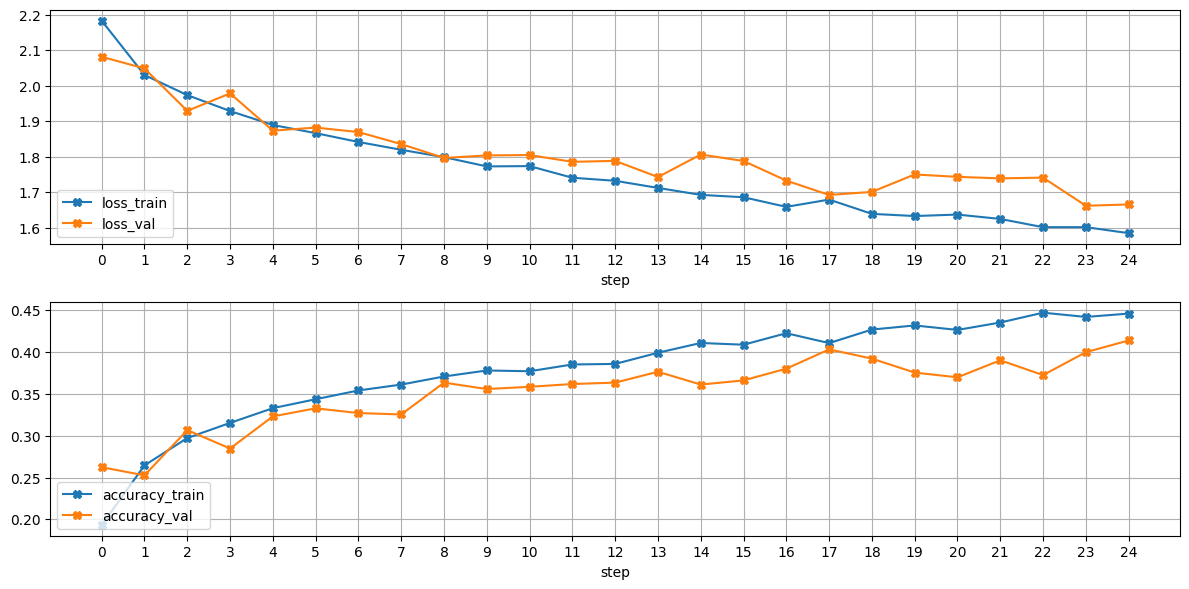

In [ ]:
history_for_plotting = []
model = FCNet().to(device)  # Create model instance
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss().to(device) # Loss function
pp = train(model, criterion, optimizer, num_epochs=25)
history_for_plotting.append(pp.history_dict)

Оценим точность на тестовом наборе данных

In [ ]:
test_accuracy, _ = calaculate_accuracy(model, test_loader,criterion)
print(f"Accuracy on TEST {test_accuracy:.2f}")

Accuracy on TEST 0.42


## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX05/result_2_task_ex05.png" width="600">

# Задание 2. Нормализация данных

Стандартизируйте данные.

* Подсчитайте среднее значение и стандартное отклонение для каждого из 3-х цветовых каналов
 * Сделайте это с помощью встроенных в torch или numpy функций
* Нормализуйте данные с использованием этих параметров (используйте трансформацию Normalize)
* Оцените влияние нормировки данных на точность обучения. (Сравните результаты обучения на сырых данных и на стандартизованных)

In [11]:
from torchvision import transforms

Mean = torch.mean(torch.tensor(dataset.data)/255).item()
Std = torch.std(torch.tensor(dataset.data)/255).item()

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(Mean, Std)])

dataset.transform = transform_with_normalize
testset.transform = transform_with_normalize


In [12]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

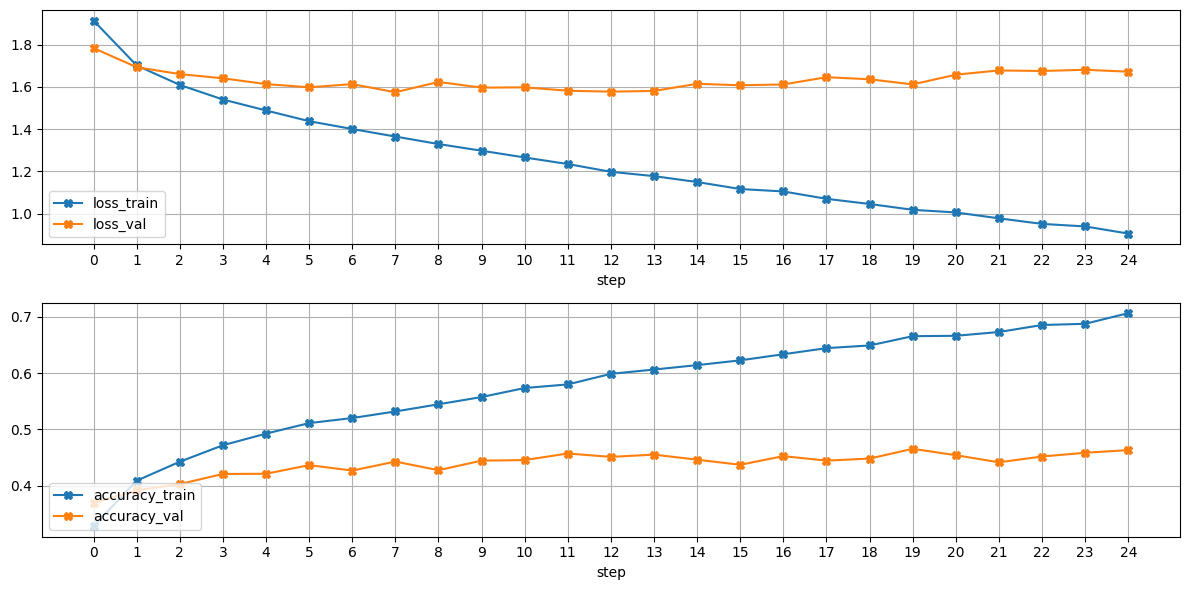

In [23]:
model = FCNet().to(device)  # Create model instance
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss().to(device) # Loss function
pp_2 = train(model, criterion, optimizer, num_epochs=25)

In [24]:
test_accuracy, _ = calaculate_accuracy(model, test_loader,criterion)
print(f"Accuracy on TEST {test_accuracy:.2f}")

Accuracy on TEST 0.46


In [ ]:
history_for_plotting.append(pp_2.history_dict)

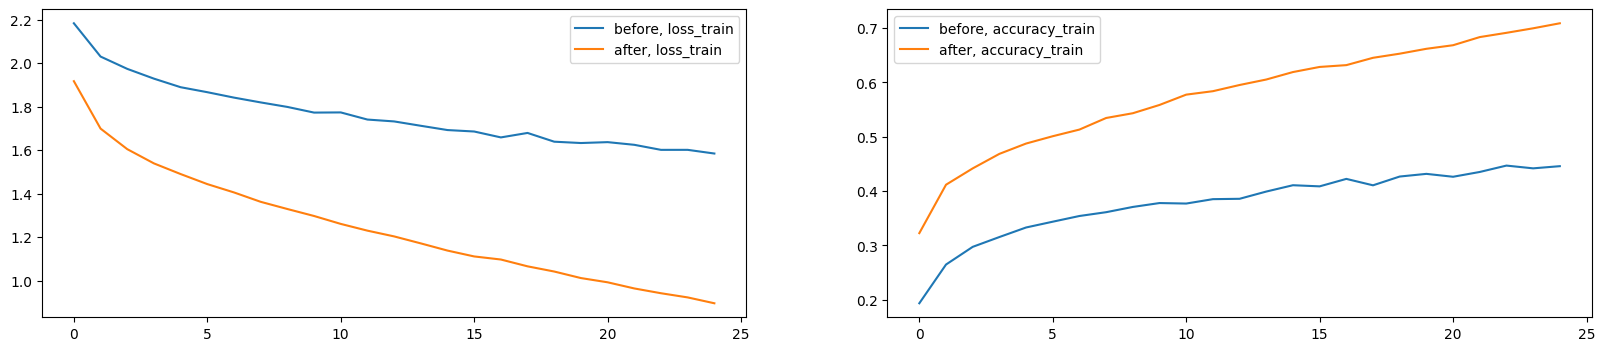

In [ ]:
history = []
history.append(pp.history_dict)
history.append(pp_2.history_dict)
tansforms = ['w/out normalize', 'w/ normalize']

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 4), sharex=False, sharey=False, gridspec_kw={'wspace':0.2,'hspace':0.2})
len_ = len(history[0]['loss_train'])

ax[0].plot(list(range(len_)), history[0]['loss_train'], label='before, loss_train')
# ax[0].plot(list(range(len_)), history[0]['loss_val'], label='before, loss_val')

ax[0].plot(list(range(len_)), history[1]['loss_train'], label='after, loss_train')
# ax[0].plot(list(range(len_)), history[1]['loss_val'], label='after, loss_val')
ax[0].legend()

ax[1].plot(list(range(len_)), history[0]['accuracy_train'], label='before, accuracy_train')
# ax[1].plot(list(range(len_)), history[0]['accuracy_val'], label='before, accuracy_val')

ax[1].plot(list(range(len_)), history[1]['accuracy_train'], label='after, accuracy_train')
# ax[1].plot(list(range(len_)), history[1]['accuracy_val'], label='after, accuracy_val')
ax[0].legend()
ax[1].legend()



## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX05/result_3_task_ex05.png" width="600">

# Задание 3. Влияние функций активации

* Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

* Используйте три функции:

 * [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
 * [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
 * [ReLU](https://pytorch.org/docs/stable/nn.functional.html#relu)
* Постройте графики потерь loss для разных функций активации в одних осях.

* Можете модифировать конструктор класса сети, чтобы была возможность передать туда желаемую функцию активации.

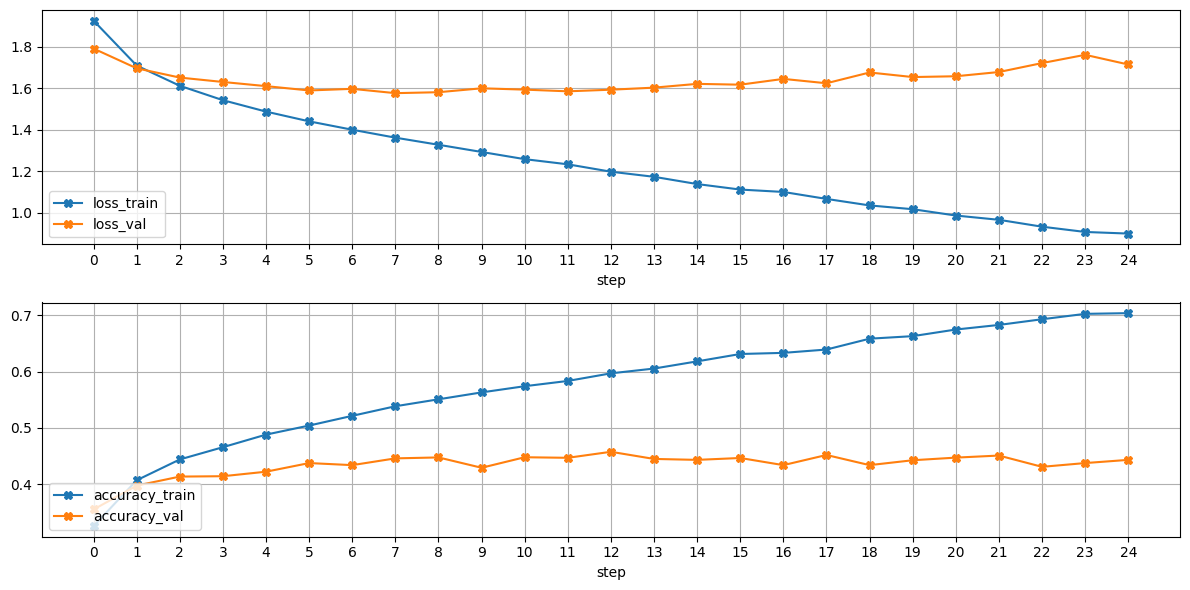

In [15]:

Models = []
Plot_history = []
activate_fun_name = ['Sigmoid', 'GELU', 'ReLU']
activate_fun = [nn.Sigmoid(), nn.GELU(), nn.ReLU()]

for func in activate_fun:
  model = FCNet().to(device)
  FCNet.relu = func
  model.train()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
  criterion = nn.CrossEntropyLoss().to(device) # Loss function
  pp = train(model, criterion, optimizer, num_epochs=25)
  Plot_history.append(pp.history_dict)
  Models.append(model)

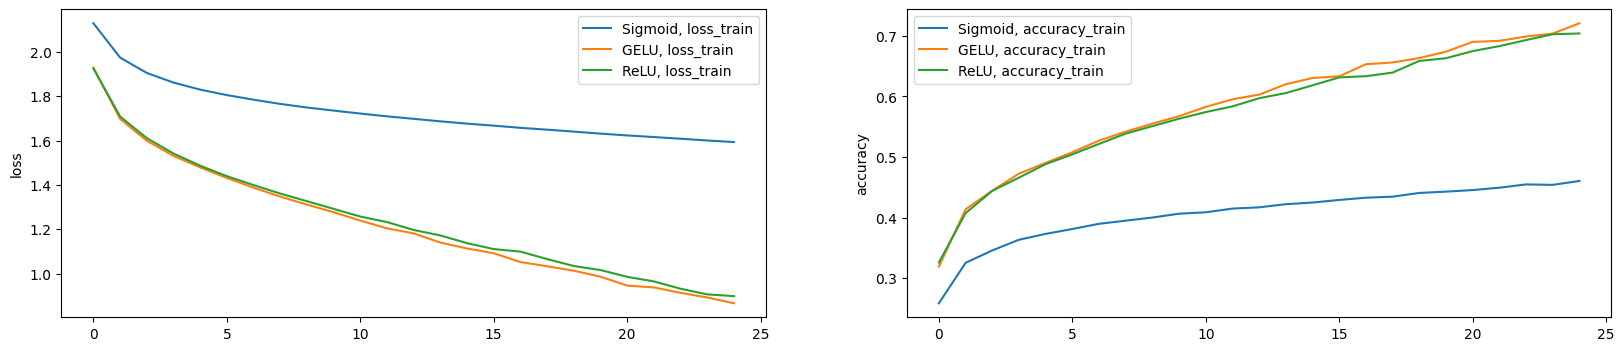

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 4), sharex=False, sharey=False, gridspec_kw={'wspace':0.2,'hspace':0.2})
len_ = len(Plot_history[0]['loss_train'])

ax[0].plot(list(range(len_)), Plot_history[0]['loss_train'], label='Sigmoid, loss_train')
# ax[0].plot(list(range(len_)), Plot_history[0]['loss_val'], label='before, loss_val')
ax[0].plot(list(range(len_)), Plot_history[1]['loss_train'], label='GELU, loss_train')
# ax[0].plot(list(range(len_)), Plot_history[1]['loss_val'], label='after, loss_val')
ax[0].plot(list(range(len_)), Plot_history[2]['loss_train'], label='ReLU, loss_train')
# ax[].plot(list(range(len_)), Plot_history[2]['loss_val'], label='after, loss_val')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(list(range(len_)), Plot_history[0]['accuracy_train'], label='Sigmoid, accuracy_train')
# ax[1].plot(list(range(len_)), Plot_history[0]['accuracy_val'], label='before, accuracy_val')

ax[1].plot(list(range(len_)), Plot_history[1]['accuracy_train'], label='GELU, accuracy_train')
# ax[1].plot(list(range(len_)), Plot_history[1]['accuracy_val'], label='after, accuracy_val')
ax[1].plot(list(range(len_)), Plot_history[2]['accuracy_train'], label='ReLU, accuracy_train')
# ax[1].plot(list(range(len_)), Plot_history[2]['accuracy_val'], label='after, accuracy_val')
ax[1].set_ylabel('accuracy')
ax[1].legend()

## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX05/result_3_task_ex05.png" width="600">

# Задание 4. Реализация ReLU

* Самостоятельно реализуйте функцию активации ReLU. (Методами torch)
* Замените в уже обученной модели функцию активации на вашу.

Убедитесь, что точность обученной модели не изменилась.




In [26]:
class CustomReLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.max(torch.tensor(0.), x)

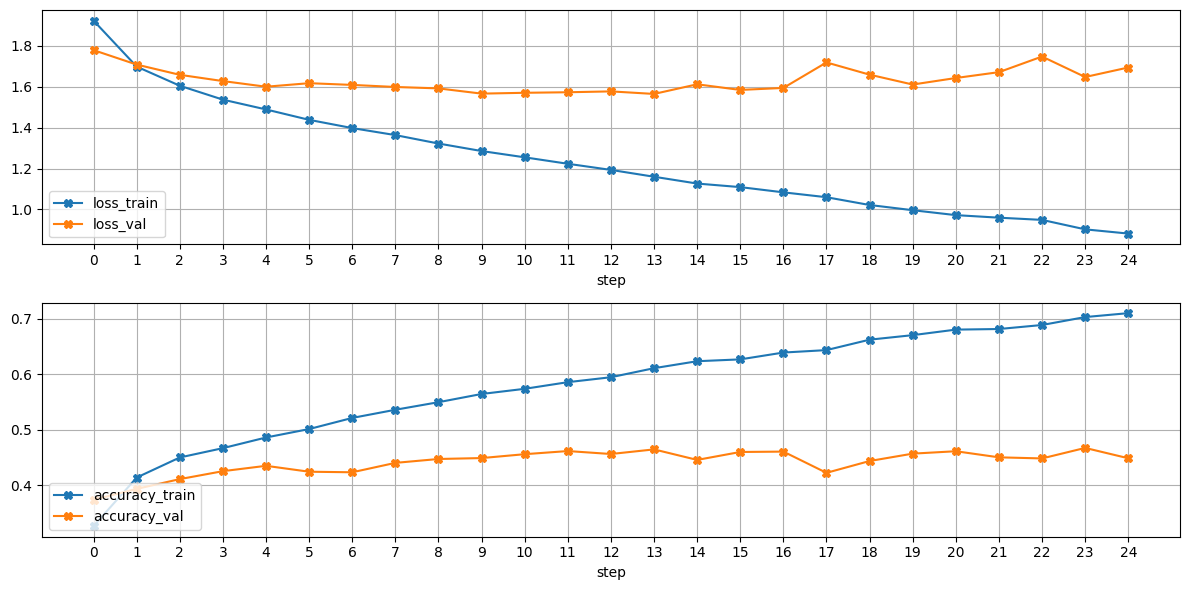

In [27]:
relu_history = []
relu_history.append(pp_2.history_dict)

model_ = FCNet().to(device)
FCNet.relu = CustomReLU()
model_.train()
optimizer = torch.optim.SGD(model_.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss().to(device) # Loss function
pp_3 = train(model_, criterion, optimizer, num_epochs=25)
relu_history.append(pp_3.history_dict)

In [28]:
test_accuracy2, _ = calaculate_accuracy(model_, test_loader,criterion)
print('Relu acc: ', test_accuracy)
print('CustomRelu acc: ', test_accuracy2)

Relu acc:  0.4577
CustomRelu acc:  0.4575


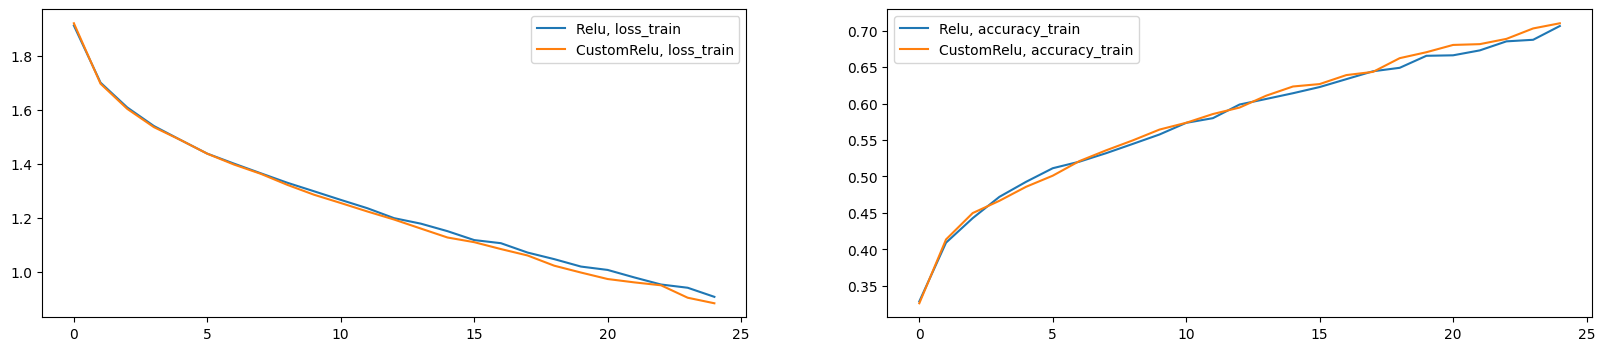

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 4), sharex=False, sharey=False, gridspec_kw={'wspace':0.2,'hspace':0.2})
len_ = len(relu_history[0]['loss_train'])

ax[0].plot(list(range(len_)), relu_history[0]['loss_train'], label='Relu, loss_train')
# ax[0].plot(list(range(len_)), history[0]['loss_val'], label='before, loss_val')

ax[0].plot(list(range(len_)), relu_history[1]['loss_train'], label='CustomRelu, loss_train')
# ax[0].plot(list(range(len_)), history[1]['loss_val'], label='after, loss_val')
ax[0].legend()

ax[1].plot(list(range(len_)), relu_history[0]['accuracy_train'], label='Relu, accuracy_train')
# ax[1].plot(list(range(len_)), history[0]['accuracy_val'], label='before, accuracy_val')

ax[1].plot(list(range(len_)), relu_history[1]['accuracy_train'], label='CustomRelu, accuracy_train')
# ax[1].plot(list(range(len_)), history[1]['accuracy_val'], label='after, accuracy_val')
ax[0].legend()
ax[1].legend()

## Формат результата
Выведите максимальное значение `accuracy` на валидационном датасете для сети со своей реализацией ReLU

# Задание 5. Классифицируйте CIFAR10 с максимальной точностью

Для этого:

*  Стандартизируйте данные
*  Подберите шаг обучения
*  Используйте весь датасет для обучения
*  При необходимости можете добавить в модель еще один скрытый слой


In [10]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


trainset, valset  = random_split(dataset, [45000, 5000])

Files already downloaded and verified
Files already downloaded and verified


In [11]:
class FCNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(3*32*32, 512)
        self.layer2 = nn.Linear(512, 128)
        self.layer3 = nn.Linear(128, 10)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)

        return x

In [13]:
from torchvision import transforms
batch_size = 256
Mean = torch.mean(torch.tensor(dataset.data)/255).item()
Std = torch.std(torch.tensor(dataset.data)/255).item()

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(Mean, Std)])

dataset.transform = transform_with_normalize
testset.transform = transform_with_normalize

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

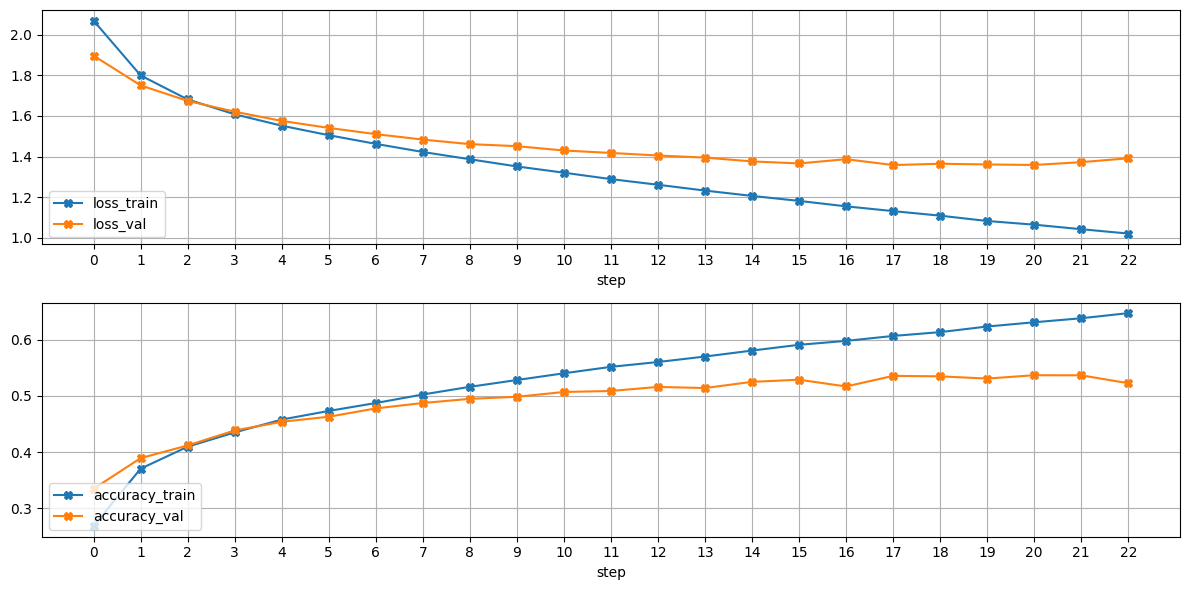

In [14]:
Model = FCNet2().to(device)  # Create model instance
Model.train()
optimizer = torch.optim.SGD(Model.parameters(), lr=0.02)  # Weight update
criterion = nn.CrossEntropyLoss().to(device) # Loss function
pp_m = train(Model, criterion, optimizer, num_epochs=23)

Оцените точность на тестовом датасете

In [15]:
test_accuracy3, _ = calaculate_accuracy(Model, test_loader,criterion)
print('New acc: ', test_accuracy3)

New acc:  0.53


## Формат результата

Выведите графики как в первом задании. Вы должны получить точность 0.48 .. 0.54